In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
L = 1.0
nx = 51
dx = L / (nx - 1)
alpha = 1.22e-3

x = numpy.linspace(0.0, L, num=nx)

T0 = numpy.zeros(nx)
T0[0] = 100.0

In [4]:
def ftcs(T0, nt, dt, dx, alpha):
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
    return T

In [5]:
nt = 100
sigma = 0.5
dt = sigma * dx**2 / alpha


T = ftcs(T0, nt, dt, dx, alpha)

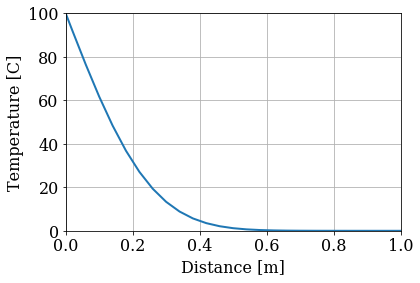

In [6]:
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [7]:
nt = 1000

T = ftcs(T0, nt, dt, dx, alpha)

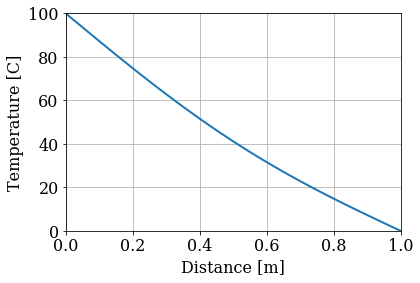

In [8]:
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [9]:
def ftcs_mixed_bcs(T0, nt, dt, dx, alpha):
    T = T0.copy()
    sigma = alpha * dt / dx**2
    for n in range(nt):
        T[1:-1] = (T[1:-1] +
                   sigma * (T[2:] - 2.0 * T[1:-1] + T[:-2]))
        # Apply Neumann condition at the last location.
        T[-1] = T[-2]
    return T

In [10]:
nt = 1000

T = ftcs_mixed_bcs(T0, nt, dt, dx, alpha)

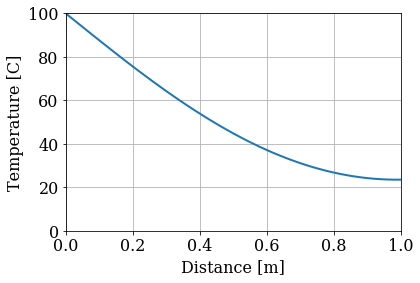

In [11]:
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [13]:
L = 1.0
nx = 51
dx = L / (nx - 1)
alpha = 1.22e-3
q = 0.0

x = numpy.linspace(0.0, L, num=nx)

T0 = numpy.zeros(nx)
T0[0] = 100.0

In [14]:
from scipy import linalg

In [15]:
def lhs_operator(N, sigma):
    """
    Computes and returns the implicit operator
    of the system for the 1D diffusion equation.
    We use backward Euler method, Dirichlet condition
    on the left side of the domain and zero-gradient
    Neumann condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size N by N.
    """
    # Setup the diagonal of the operator.
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1.0 + 1.0 / sigma
    # Setup the upper diagonal of the operator.
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A

In [16]:
?numpy.diag()

In [17]:
def rhs_vector(T, sigma, qdx):
    """
    Computes and returns the right-hand side of the system
    for the 1D diffusion equation, using a Dirichlet condition
    on the left side and a Neumann condition on the right side.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    sigma : float
        Value of alpha * dt / dx**2.
    qdx : float
        Value of the temperature flux at the right side.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats.
    """
    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += qdx
    return b

In [18]:
def btcs_implicit(T0, nt, dt, dx, alpha, q):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Euler implicit in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    q : float
        Value of the temperature gradient on the right side.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector(T, sigma, q * dx)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = linalg.solve(A, b)
        # Apply the Neumann boundary condition.
        T[-1] = T[-2] + q * dx
    return T

In [19]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx**2 / alpha  # time-step size
nt = 1000  # number of time steps to compute

# Compute the temperature along the rod.
T = btcs_implicit(T0, nt, dt, dx, alpha, q)

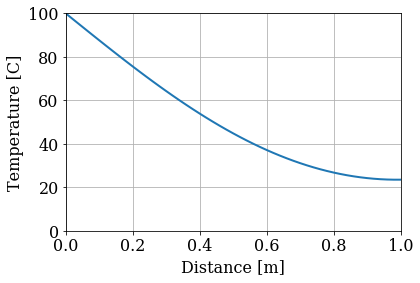

In [20]:
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [21]:
def ftcs(T0, nt, dt, dx, dy, alpha):
    """
    Computes and returns the temperature distribution
    after a given number of time steps.
    Explicit integration using forward differencing
    in time and central differencing in space, with
    Neumann conditions (zero-gradient) on top and right
    boundaries and Dirichlet conditions on bottom and
    left boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Maximum number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x direction.
    dy : float
        Grid spacing in the y direction.
    alpha : float
        Thermal diffusivity.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Define some constants.
    sigma_x = alpha * dt / dx**2
    sigma_y = alpha * dt / dy**2
    # Integrate in time.
    T = T0.copy()
    ny, nx = T.shape
    I, J = int(nx / 2), int(ny / 2)  # indices of the center
    for n in range(nt):
        T[1:-1, 1:-1] = (T[1:-1, 1:-1] +
                         sigma_x * (T[1:-1, 2:] - 2.0 * T[1:-1, 1:-1] + T[1:-1, :-2]) +
                         sigma_y * (T[2:, 1:-1] - 2.0 * T[1:-1, 1:-1] + T[:-2, 1:-1]))
        # Apply Neumann conditions (zero-gradient).
        T[-1, :] = T[-2, :]
        T[:, -1] = T[:, -2]
        # Check if the center of the domain has reached T = 70C.
        if T[J, I] >= 70.0:
            break
    print('[time step {}] Center at T={:.2f} at t={:.2f} s'
          .format(n + 1, T[J, I], (n + 1) * dt))
    return T

In [22]:
Lx = 0.01  # length of the plate in the x direction
Ly = 0.01  # height of the plate in the y direction
nx = 21  # number of points in the x direction
ny = 21  # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction
alpha = 1e-4  # thermal diffusivity of the plate

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Compute the initial temperature distribution.
Tb = 100.0  # temperature at the left and bottom boundaries
T0 = 20.0 * numpy.ones((ny, nx))
T0[0, :] = Tb
T0[:, 0] = Tb

In [23]:
# Set the time-step size based on CFL limit.
sigma = 0.25
dt = sigma * min(dx, dy)**2 / alpha  # time-step size
nt = 500  # number of time steps to compute

# Compute the temperature along the rod.
T = ftcs(T0, nt, dt, dx, dy, alpha)

[time step 256] Center at T=70.02 at t=0.16 s


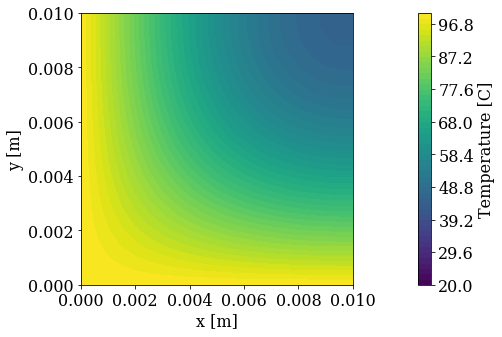

In [24]:
# Plot the filled contour of the temperature.
pyplot.figure(figsize=(8.0, 5.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
levels = numpy.linspace(20.0, 100.0, num=51)
contf = pyplot.contourf(x, y, T, levels=levels)
cbar = pyplot.colorbar(contf)
cbar.set_label('Temperature [C]')
pyplot.axis('scaled', adjustable='box');